In [499]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns


# Homemade functions

In [214]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [215]:
"""
Okay, this function is the most complicated part of the analysis. It organizes the raw events file 
into a pandas dataframe. 
"""

def create_events_df(participant_raw_events, trials_num, TR):

    run1_events = pd.DataFrame(columns={"onset", "duration", "trial_type"}) 

    # Iterate through every trial. 
    for x in range(trials_num): 

        trial_onset = participant_raw_events["onset"][x]
        anticipation_onset = trial_onset #+ TR/2
        anticipation_duration = 2

        response_onset = trial_onset + participant_raw_events["response_time"][x] #+ TR/2
        response_duration = 0.5

        outcome_lag = 7
        outcome_onset = trial_onset + outcome_lag #+ TR/2
        outcome_duration = 2

        current_trial = participant_raw_events["trial_type"][x]
        current_hit = participant_raw_events["hit"][x]
    
        # Determine event type for anticipation period.
        if(current_trial == "-$0"):
            current_trialtype = "nonloss"
            response_trial = "response"
        elif(current_trial == "+$0"):
            current_trialtype = "nongain"
            response_trial = "response"
        elif(current_trial == "+$5"):
            current_trialtype = "large_gain"
            response_trial = "response"
        elif(current_trial == "-$5"):
            current_trialtype = "large_loss"
            response_trial = "response"
        elif(current_trial == "+$1"):
            current_trialtype = "medium_gain"
            response_trial = "response"
        elif(current_trial == "-$1"):
            current_trialtype = "medium_loss"
            response_trial = "response"
        else:
            print(f"There appears to be an error with trial {x}")
    
        if(current_hit == 1):
            #current_trialtype = current_trialtype + "_hit"
            current_outcome_type = "outcome_" + current_trialtype 
        else:
            #current_trialtype = current_trialtype + "_miss"
            current_outcome_type = "outcome_zero" + "_miss"

        # Place anticipation data on list, add list to new dataframe, and concat to main dataframe. 
        anticipation_data = [[anticipation_onset, anticipation_duration, current_trialtype]]
        current_row = pd.DataFrame(data=anticipation_data, columns=["onset", "duration", "trial_type"]) 
        run1_events = pd.concat([run1_events, current_row], ignore_index=True)

        if(current_hit == 1):
            response_data = [[response_onset, response_duration, response_trial]]
            response_row = pd.DataFrame(data=response_data, columns=["onset", "duration", "trial_type"]) 
            run1_events = pd.concat([run1_events, response_row], ignore_index=True)  
        
        # Place outcome data on list, add list to new dataframe, and concat to main dataframe. 
        current_outcome_row = pd.DataFrame(data=[[outcome_onset, outcome_duration, current_outcome_type]], columns=["onset", "duration", "trial_type"])
        run1_events = pd.concat([run1_events, current_outcome_row], ignore_index=True)

    return run1_events


# Run GLM on Subject 001

## Load func files.

In [216]:
# Load files for sub 001  
sub01_run1_func_file = "MID_preproc/sub-01/func/sub-01_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub01_run1_mask_file = "MID_preproc/sub-01/func/sub-01_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub01_file = 'MID_raw/sub-01/func/sub-01_task-MID_run-1_events.tsv'
sub01_run1_confounds_file = "MID_preproc/sub-01/func/sub-01_task-MID_run-1_desc-confounds_timeseries.tsv"


In [217]:
# Calculate mean image to use as background image (not really used).
fmri_img = concat_imgs(sub01_run1_func_file)
mean_img = mean_img(fmri_img)

func_file = nib.load(sub01_run1_func_file)
func_data = func_file.get_data()

print("File of fist run 1 has shape: %s" % str(func_data.shape))

# Calculate relevant parameters for GLM and ROI time-course analysis.
n_vols = func_data.shape[3]
TR = 2
n_timepoints = n_vols*TR


/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_23903/1647694536.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


## Create events df for design matrix.

In [218]:
# Load participants file and get number of trials.
run1_events_raw = pd.read_csv(sub01_file, sep='\t')
trials_num = run1_events_raw.shape[0]

print(f"run1_events shape: {run1_events_raw.shape}")
print(f"Run 1 number of trials: {trials_num}")

run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


,onset,duration,trial,trial_type,target_s,response_time,hit,total_gain,iti
0,12.0001,10,1,-$0,0.25,-1.00000,0,$0.00,6
1,26.0008,10,2,-$1,0.25,0.20167,1,$0.00,6
2,40.0008,6,3,+$0,0.25,0.21764,1,$0.00,2
3,50.0008,8,4,+$5,0.25,-1.00000,0,$0.00,4
4,62.0006,10,5,+$0,0.25,0.19340,1,$0.00,6


In [219]:
# Create events dataframe for sub001 run 1.
run1_events = create_events_df(run1_events_raw, trials_num, TR)

run1_events.head()

,duration,onset,trial_type
0,2,12.00010,nonloss
1,2,19.00010,outcome_zero_miss
2,2,26.00080,medium_loss
3,0.5,26.20247,response
4,2,33.00080,outcome_medium_loss


## Load confounds

In [220]:
# Load confounds file for sub001 run 1. 
sub01_run1_confounds_df = pd.read_csv(sub01_run1_confounds_file, sep='\t')
default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", 
                         "tcompcor", "white_matter", "csf", "framewise_displacement", "dvars"]

# Add confound columns if they contain 'motion' in the title. 
sub01_motion_confounds = [i for i in sub01_run1_confounds_df.columns if "motion" in i] 
sub01_run1_filtered_confounds_df = sub01_run1_confounds_df[default_confounds + sub01_motion_confounds]

# Change NaNs to 0s. 
sub01_run1_filtered_confounds_df = sub01_run1_filtered_confounds_df.fillna(0) 
sub01_run1_filtered_confounds_df.head()

,trans_y,trans_x,trans_z,rot_y,rot_x,rot_z,global_signal,tcompcor,white_matter,csf,framewise_displacement,dvars,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03
0,-0.018002,0.012779,0.025662,-0.000003,-0.001103,-0.000237,2628.102493,2493.688425,2098.845147,2448.524704,0.000000,0.000000,0.0,0.0,0.0,0.0
1,-0.022231,-0.028052,0.184587,-0.001080,-0.000338,0.000407,2056.264792,1797.162394,1752.003107,1591.517557,0.328249,328.325653,1.0,0.0,0.0,0.0
2,-0.034712,-0.023609,0.272411,-0.001366,-0.000389,0.000407,2021.428054,1762.319762,1742.118423,1569.099119,0.121616,29.925766,0.0,1.0,0.0,0.0
3,0.015160,-0.007666,0.281848,-0.001949,-0.000050,0.000407,2012.364464,1736.316780,1738.769800,1556.827503,0.121378,14.952096,0.0,0.0,0.0,0.0
4,-0.036387,0.003322,0.289119,-0.002187,0.000124,0.000407,2013.244090,1726.501571,1738.736461,1554.128825,0.090373,12.749180,0.0,0.0,0.0,0.0


## Creat First Level GLM

In [221]:
# Create GLM object. 
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5,
    mask_img=sub01_run1_mask_file,
    smoothing_fwhm = 4)

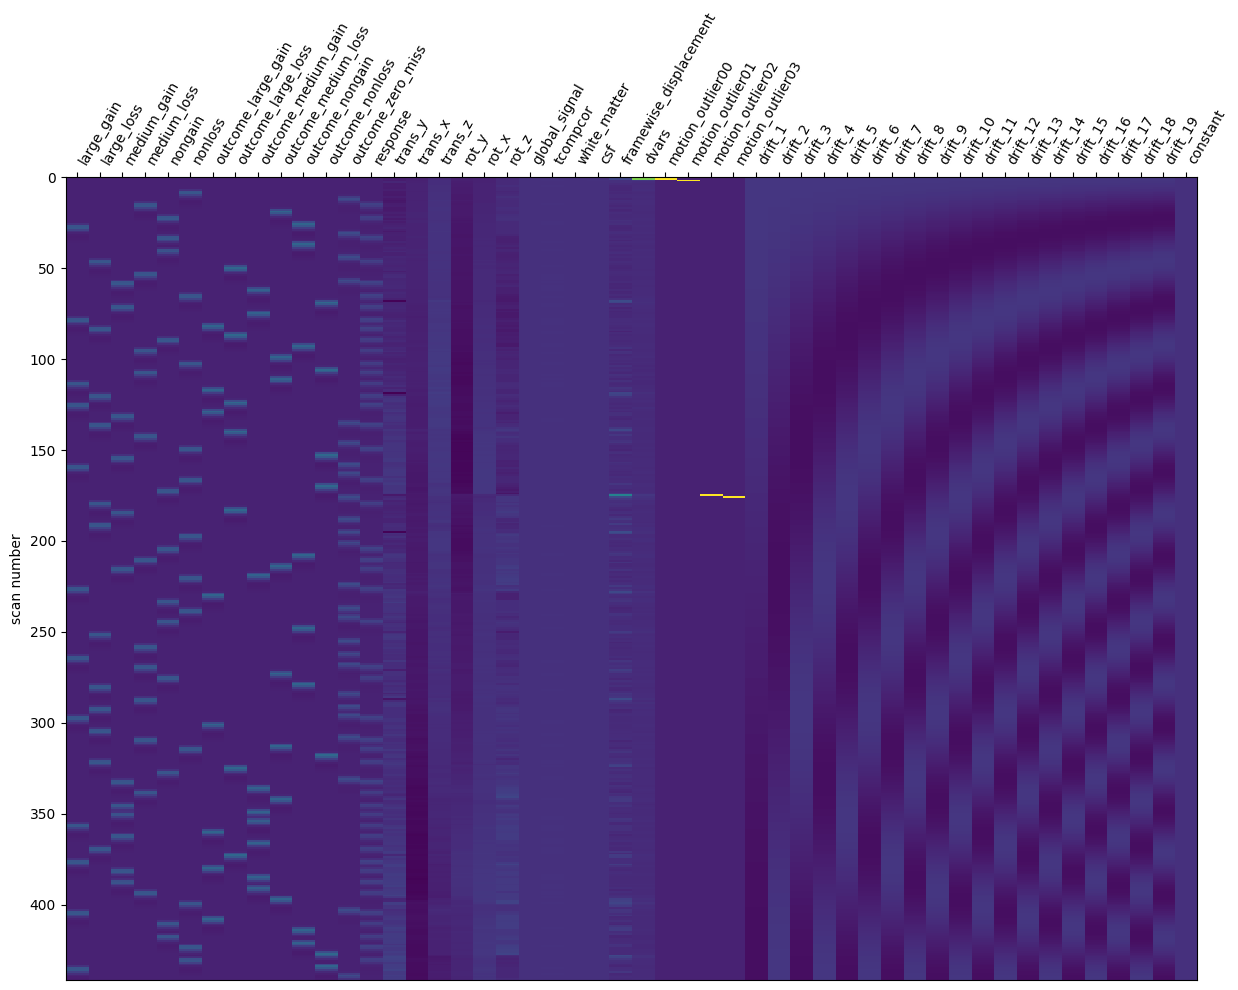

In [222]:
# Fit GLM model. Note it requires as input the fmri file, the events dataframe, and the confounds dataframe. 
fmri_glm = fmri_glm.fit(sub01_run1_func_file, run1_events, sub01_run1_filtered_confounds_df)

plot_design_matrix(fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.009


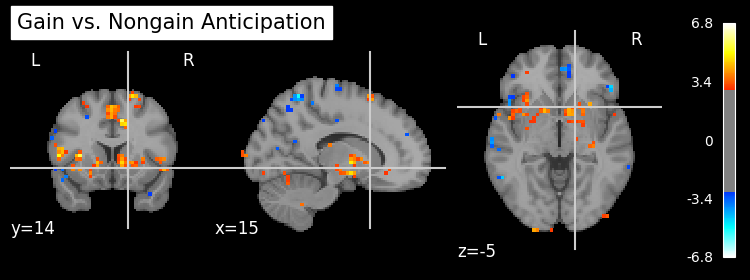

In [223]:
# Create the orthogonal contrast to the create image. Note, the sum of all elements equals zero.
anticipation_gain_contrast = "+1*large_gain+1*medium_gain-2*nongain"

anticipation_gain_z_map = fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, stat_type="t", output_type="z_score")

anticipation_gain_thresholded_map, threshold = threshold_stats_img(anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



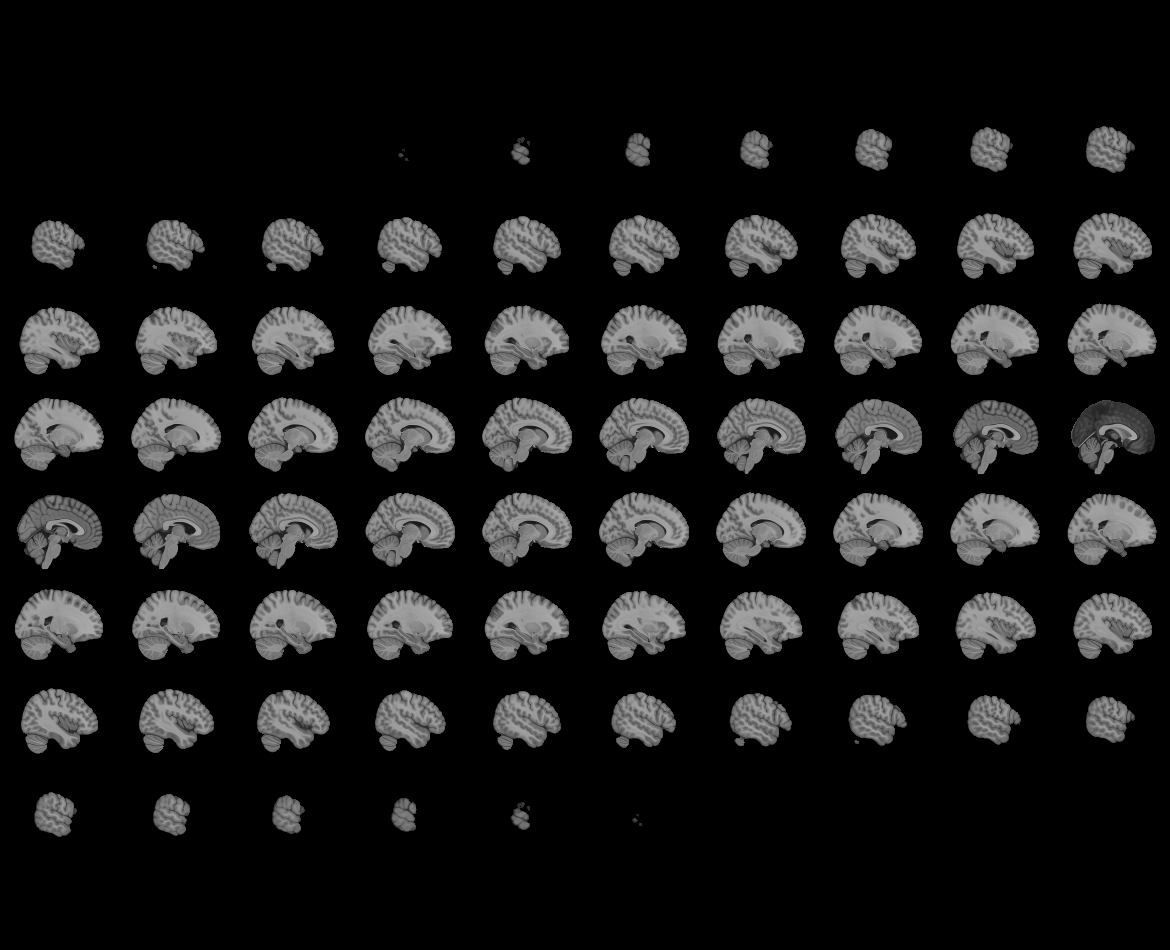
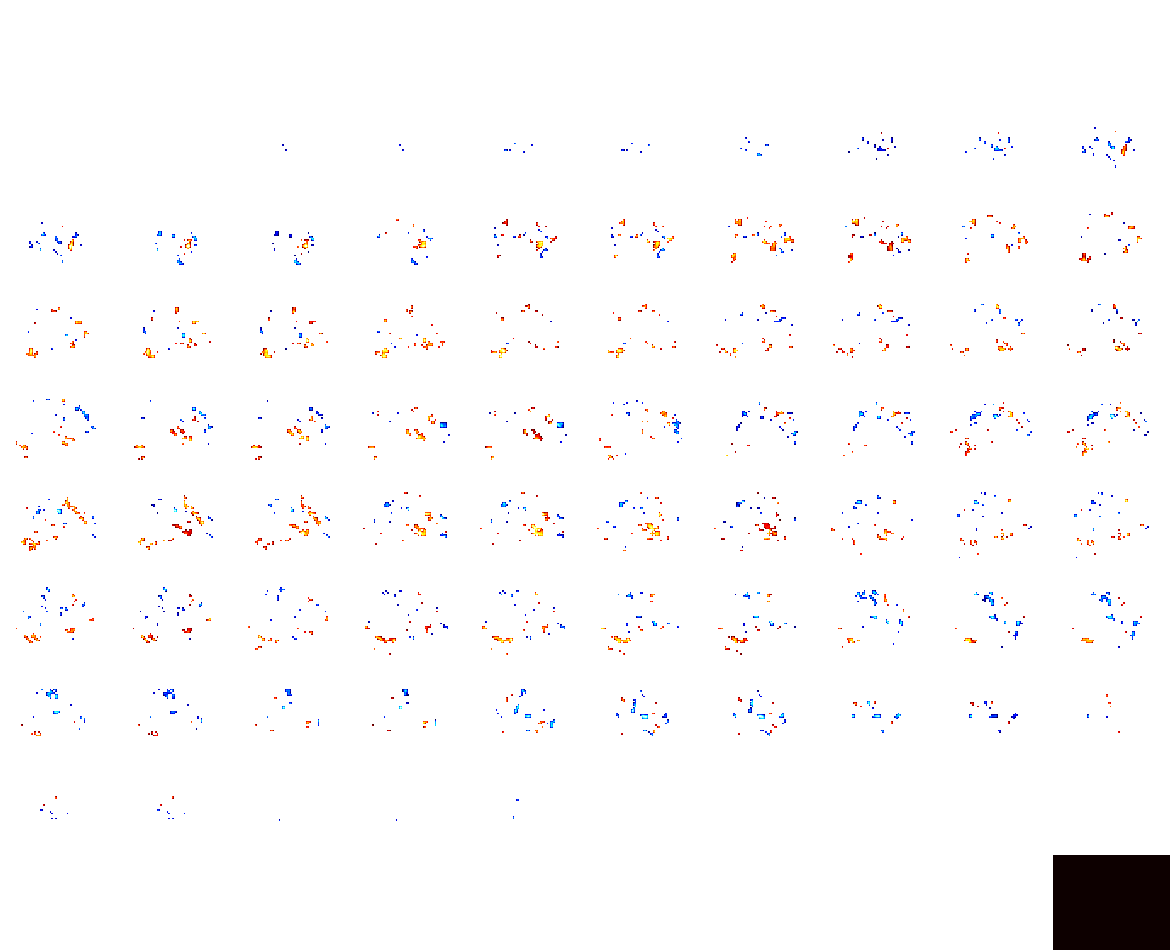

In [224]:
view = view_img(anticipation_gain_thresholded_map, threshold=threshold, cut_coords=[15, 14, -5])

view

# Slice func file to difference events. 

In [274]:
# Obtain the onsets (as a column) for each trial type (large, medium, and non gain) and store it in a new array type int.
large_gain_onsets = np.array(run1_events[run1_events["trial_type"] == "large_gain"]["onset"]).astype(int)
medium_gain_onsets = np.array(run1_events[run1_events["trial_type"] == "medium_gain"]["onset"]).astype(int)
non_gain_onsets = np.array(run1_events[run1_events["trial_type"] == "nongain"]["onset"]).astype(int)


In [275]:
# Down-sample predictors to get vol onsets. 

# Create array from 0 to 'n_timepoints' in steps of 1.
time_scale = np.arange(0, n_timepoints, 1)  

# Create array of zeros to store all time points. 
# Assign a 1 to the corresponding onsets. 
large_gain_time_onsets = np.zeros(n_timepoints)
large_gain_time_onsets[large_gain_onsets] = 1
medium_gain_time_onsets = np.zeros(n_timepoints)
medium_gain_time_onsets[medium_gain_onsets] = 1
non_gain_time_onsets = np.zeros(n_timepoints)
non_gain_time_onsets[non_gain_onsets] = 1
print("Time scale has %i datapoints" % time_scale.size)

# Create resampler objects for each type of reward.
resampler_lg = interp1d(time_scale, large_gain_time_onsets)
resampler_mg = interp1d(time_scale, medium_gain_time_onsets)
resampler_ng = interp1d(time_scale, non_gain_time_onsets)

# Create array from 0 to 'n_timepoints' in steps of 2.
vol_scale = np.arange(0, n_timepoints, TR)  
print("Vol scale has %i datapoints" % vol_scale.size)

# Create downsampled arrays for each reward type. 
# Note this vol arrays are half the length than the time arrays.
large_gain_vol_onsets = resampler_lg(vol_scale)
medium_gain_vol_onsets = resampler_mg(vol_scale)
non_gain_vol_onsets = resampler_ng(vol_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % large_gain_vol_onsets.size)


Time scale has 884 datapoints
Vol scale has 442 datapoints
Downsampled predictor has 442 datapoints (in volumes)


# Use Sphere Mask on NAcc. 

In [520]:
#NAcc (Talairach coordinates: [+10, 12, -2], [-10, 12, -2]) from

# Init the sphere masking object. 
# Note, I am using to seeds one for right and one for left NAcc. 
# The sphere has a radius of 8 mm. 
# I'm filtering out both high an low frequencies. 
masker_sNAcc = NiftiSpheresMasker(
    #seeds=[(15, 14, -5)],
    seeds=[(10, 12, -2), (-10, 12, -2)],  # right, left
    radius=8, 
    standardize="zscore",  #probably change to False, but adjust figures. , psc
    t_r=2,
    standardize_confounds=True,
    high_pass=0.011,
    low_pass=0.1)

# Mask the epi data and get a time series for the ROI. 
# Note this is similar to fitting the GLM, but without the event files.
bold_sNAcc = masker_sNAcc.fit_transform(sub01_run1_func_file, confounds=sub01_run1_filtered_confounds_df)
print("bold_rNAcc has a shape: %s" % str(bold_sNAcc.shape))


bold_rNAcc has a shape: (442, 2)


# Derive ROI time courses for each reward size. 

In [521]:
# Extract segments around stimulus onsets for condition 1

# Determine if it's left of right NAcc...
#bold_sNAcc_lg_right = np.array([bold_sNAcc[idx - 2: idx + 6][:, 0] for idx in range(large_gain_vol_onsets.shape[0]) if (large_gain_vol_onsets[idx] > 0) and (large_gain_vol_onsets[idx + 4] <= len(bold_sNAcc))])
#bold_sNAcc_lg_left = np.array([bold_sNAcc[idx - 2: idx + 6][:, 1] for idx in range(large_gain_vol_onsets.shape[0]) if (large_gain_vol_onsets[idx] > 0) and (large_gain_vol_onsets[idx + 4] <= len(bold_sNAcc))])
bold_sNAcc_lg_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(large_gain_vol_onsets.shape[0]) if (large_gain_vol_onsets[idx] > 0) and (large_gain_vol_onsets[idx + 4] <= len(bold_sNAcc))])
#[bold_sNAcc[idx - 1: idx + 4] for idx in large_gain_vol_onsets.astype(int) if (idx > 0) and (idx + 4 <= len(bold_sNAcc))]
bold_sNAcc_lg_bi_mean = np.mean(bold_sNAcc_lg_bi, axis=0)

# Extract segments around stimulus onsets for condition 2
bold_sNAcc_mg_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(medium_gain_vol_onsets.shape[0]) if (medium_gain_vol_onsets[idx] > 0) and (medium_gain_vol_onsets[idx + 4] <= len(bold_sNAcc))])
bold_sNAcc_mg_bi_mean = np.mean(bold_sNAcc_mg_bi, axis=0)

# Extract segments around stimulus onsets for condition 3
bold_sNAcc_ng_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(non_gain_vol_onsets.shape[0]) if (non_gain_vol_onsets[idx] > 0) and (non_gain_vol_onsets[idx + 4] <= len(bold_sNAcc))])
bold_sNAcc_ng_bi_mean = np.mean(bold_sNAcc_ng_bi, axis=0)

# 12 events, 5 time points, 2 rois.
print("bold_sNAcc_lg_bi has a shape: %s" % str(bold_sNAcc_lg_bi.shape))
print("bold_sNAcc_mg_bi has a shape: %s" % str(bold_sNAcc_mg_bi.shape))
print("bold_sNAcc_ng_bi has a shape: %s" % str(bold_sNAcc_ng_bi.shape))


bold_sNAcc_lg_bi has a shape: (12, 10)
bold_sNAcc_mg_bi has a shape: (12, 10)
bold_sNAcc_ng_bi has a shape: (12, 10)


Text(0.5, 1.0, 'Bilateral NAcc anticipatory activity for all rewards')

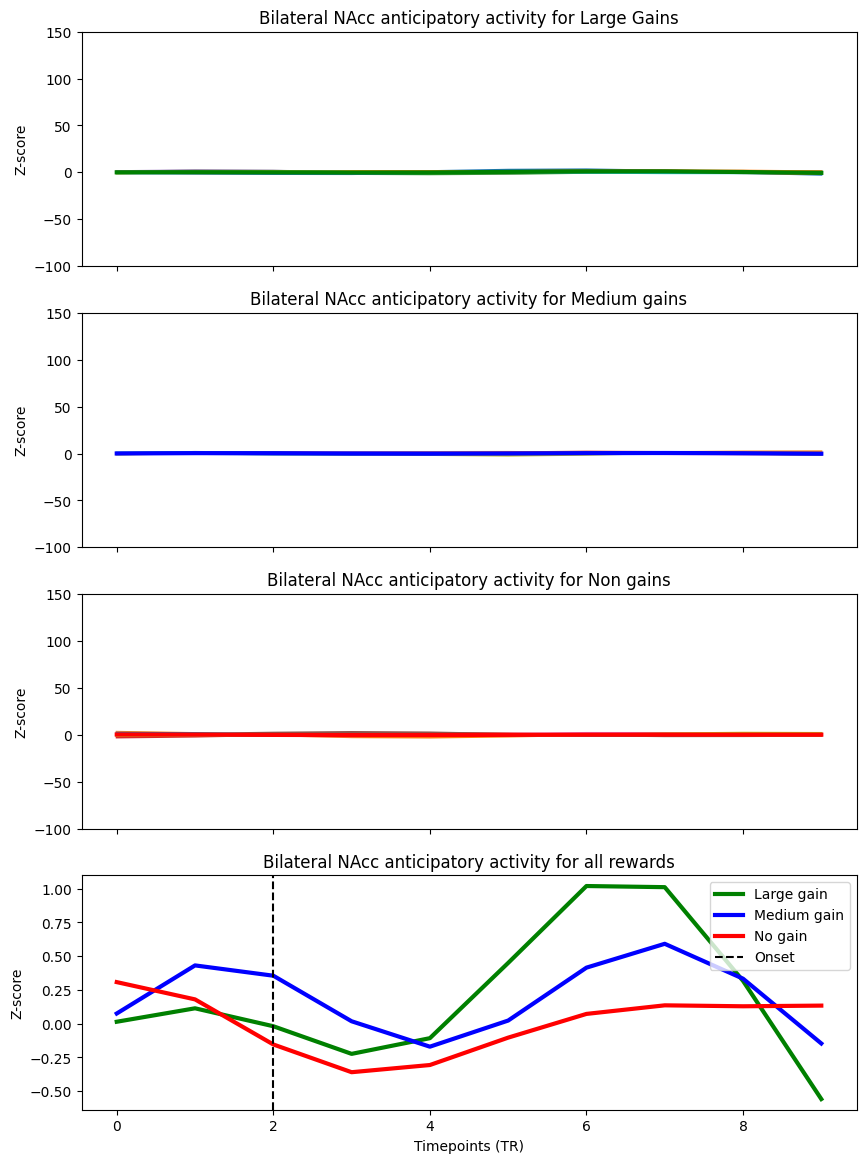

In [527]:
fig, axs = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

for x in range(12):
    axs[0].plot(bold_sNAcc_lg_bi[x][:])
    axs[1].plot(bold_sNAcc_mg_bi[x][:])
    axs[2].plot(bold_sNAcc_ng_bi[x][:])

axs[0].set_ylim(-100, 150)
axs[1].set_ylim(-100, 150)
axs[2].set_ylim(-100, 150)
axs[0].set_ylabel('Z-score')
axs[1].set_ylabel('Z-score')
axs[2].set_ylabel('Z-score')
axs[0].set_title("Bilateral NAcc anticipatory activity for Large Gains")
axs[1].set_title("Bilateral NAcc anticipatory activity for Medium gains")
axs[2].set_title("Bilateral NAcc anticipatory activity for Non gains")

axs[0].plot(bold_sNAcc_lg_bi_mean[:], 'g', lw=3)
axs[1].plot(bold_sNAcc_mg_bi_mean[:], 'b', lw=3)
axs[2].plot(bold_sNAcc_ng_bi_mean[:], 'r', lw=3)

axs[3].plot(bold_sNAcc_lg_bi_mean[:], 'g', lw=3)
axs[3].plot(bold_sNAcc_mg_bi_mean[:], 'b', lw=3)
axs[3].plot(bold_sNAcc_ng_bi_mean[:], 'r', lw=3)
axs[3].axvline(x = 2, color = 'k', label = 'onset', linestyle='dashed')

axs[3].legend(('Large gain', 'Medium gain', 'No gain', 'Onset'))
axs[3].set_ylabel('Z-score')
axs[3].set_xlabel('Timepoints (TR)')
axs[3].set_title("Bilateral NAcc anticipatory activity for all rewards")


In [505]:
# Create a list of event categories and stimuli
event_categories = ["Large_gain", "Medium_gain", "Non_gain"]
stimuli = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
signal_array = np.array([bold_sNAcc_lg_bi, bold_sNAcc_mg_bi, bold_sNAcc_ng_bi])

# Initialize empty lists to store data
timepoints = []
events = []
stimulus_list = []
signals = []

for event_category in range(3):
    for stimulus in range(0, 12):
        for timepoint in range(0, 10):  # Assuming 10 timepoints
            timepoints.append(timepoint)
            events.append(event_categories[event_category])
            stimulus_list.append(str(event_categories[event_category] + stimuli[stimulus]))
            signals.append(signal_array[event_category, stimulus, timepoint])

# Create the DataFrame
data = {
    'TR': timepoints,
    'event': events,
    'stimulus': stimulus_list,
    'Z-score': signals
}

bold_sNAcc_bi_df = pd.DataFrame(data)
bold_sNAcc_bi_df.head()


,TR,event,stimulus,Z-score
0,0,Large_gain,Large_gain01,-44.050464
1,1,Large_gain,Large_gain01,-49.622026
2,2,Large_gain,Large_gain01,-44.942172
3,3,Large_gain,Large_gain01,-10.938082
4,4,Large_gain,Large_gain01,56.031565


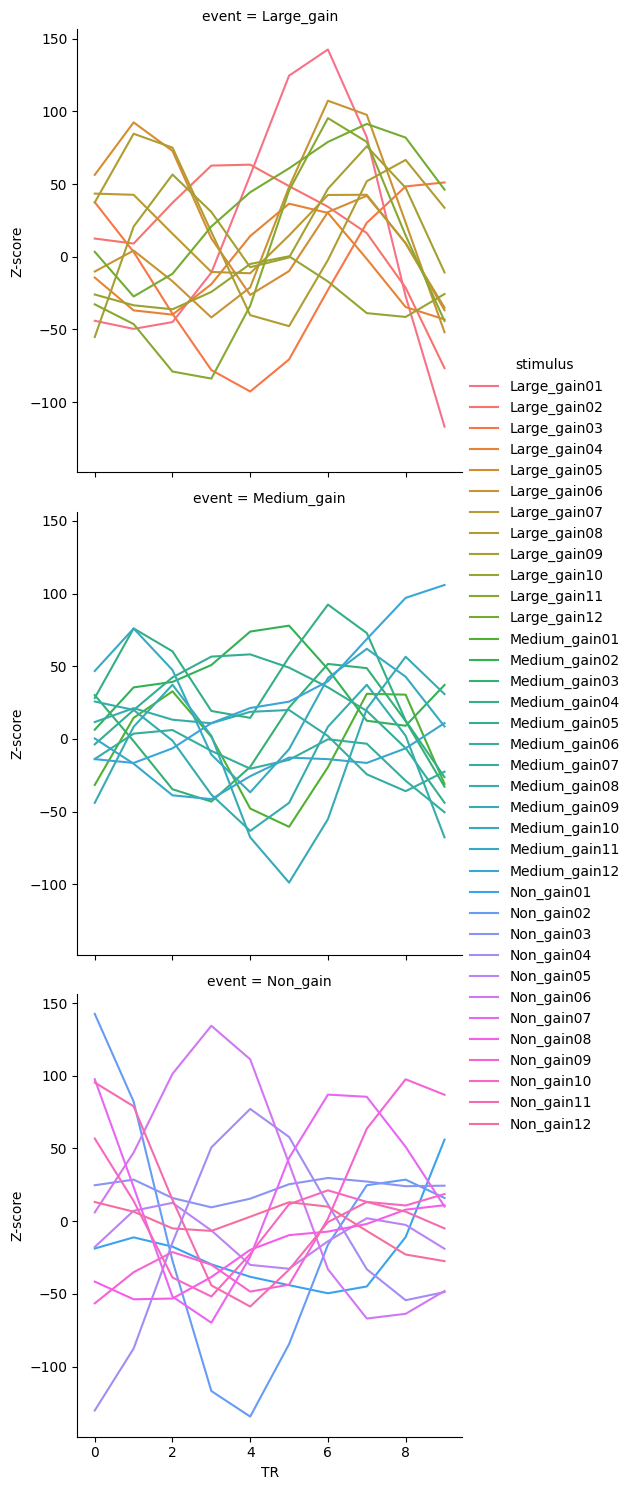

In [506]:

sns.relplot(data=bold_sNAcc_bi_df, x="TR", y="Z-score", hue="stimulus", row="event", kind="line")

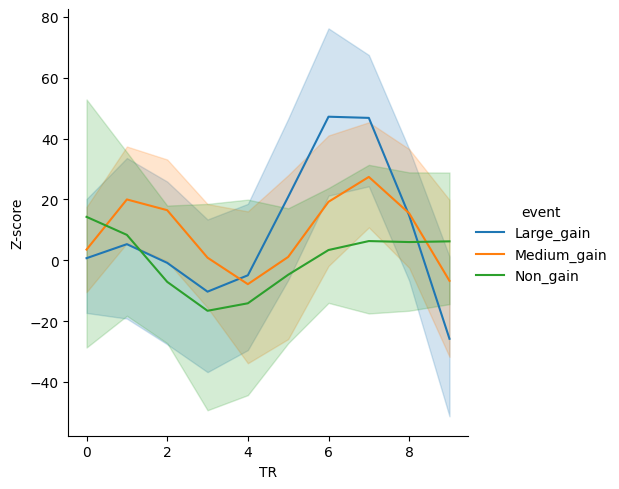

In [507]:

sns.relplot(data=bold_sNAcc_bi_df, x="TR", y="Z-score", hue="event", kind="line")

# Load and check Pauli et al. (2018) sub-cortical brain atlas.

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


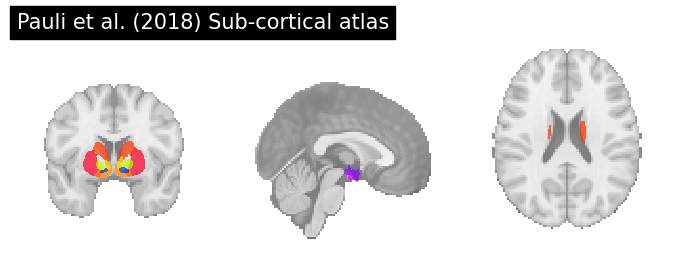

In [508]:
# Load pauli file. 
pauli_file = "CIT168_Reinf_Learn_v1.1.0/prob_atlas_bilateral.nii.gz"

plot_prob_atlas(pauli_file, cut_coords=None, title="Pauli et al. (2018) Sub-cortical atlas", annotate=False, draw_cross=False) #cut_coords=[15, 14, -5]

In [554]:
NAcc_map = index_img(pauli_file, [10])

plot_prob_atlas(NAcc_map, cut_coords=[15, 14, -5], title="Pauli et al. (2018): NAcc", annotate=False, draw_cross=False) #

In [551]:
# NiftiMapsMasker
masker_Pauli_NAcc = NiftiMapsMasker(
    maps_img=NAcc_map, 
    #mask_img=sub01_run1_mask_file,
    resampling_target="data",
    standardize="zscore", 
    t_r=2,
    standardize_confounds=True,
    high_pass=0.011,
    low_pass=0.1
    )

# Mask the epi data and get a time series for the ROI. 
# Note this is similar to fitting the GLM, but without the event files.
bold_Pauli_NAcc = masker_Pauli_NAcc.fit_transform(sub01_run1_func_file, confounds=sub01_run1_filtered_confounds_df)
print("bold_rNAcc has a shape: %s" % str(bold_Pauli_NAcc.shape))

bold_rNAcc has a shape: (442, 1)


In [552]:
# Extract segments around stimulus onsets for condition 1.
bold_pNAcc_lg= np.array([np.nanmean(bold_Pauli_NAcc[idx - 2: idx + 8][:], axis=1) for idx in range(large_gain_vol_onsets.shape[0]) if (large_gain_vol_onsets[idx] > 0) and (large_gain_vol_onsets[idx + 4] <= len(bold_Pauli_NAcc))])
bold_pNAcc_lg_mean = np.nanmean(bold_pNAcc_lg, axis=0)

# Extract segments around stimulus onsets for condition 2.
bold_pNAcc_mg = np.array([np.nanmean(bold_Pauli_NAcc[idx - 2: idx + 8][:], axis=1) for idx in range(medium_gain_vol_onsets.shape[0]) if (medium_gain_vol_onsets[idx] > 0) and (medium_gain_vol_onsets[idx + 4] <= len(bold_Pauli_NAcc))])
bold_pNAcc_mg_mean = np.nanmean(bold_pNAcc_mg, axis=0)

# Extract segments around stimulus onsets for condition 3.
bold_pNAcc_ng = np.array([np.nanmean(bold_Pauli_NAcc[idx - 2: idx + 8][:], axis=1) for idx in range(non_gain_vol_onsets.shape[0]) if (non_gain_vol_onsets[idx] > 0) and (non_gain_vol_onsets[idx + 4] <= len(bold_Pauli_NAcc))])
bold_pNAcc_ng_mean = np.nanmean(bold_pNAcc_ng, axis=0)

# 12 events, 5 time points, 2 rois.
print("bold_pNAcc_lg has a shape: %s" % str(bold_pNAcc_lg.shape))
print("bold_pNAcc_mg has a shape: %s" % str(bold_pNAcc_mg.shape))
print("bold_pNAcc_ng has a shape: %s" % str(bold_pNAcc_ng.shape))

bold_pNAcc_lg has a shape: (12, 10)
bold_pNAcc_mg has a shape: (12, 10)
bold_pNAcc_ng has a shape: (12, 10)


Text(0.5, 1.0, 'Bilateral NAcc anticipatory activity for all rewards')

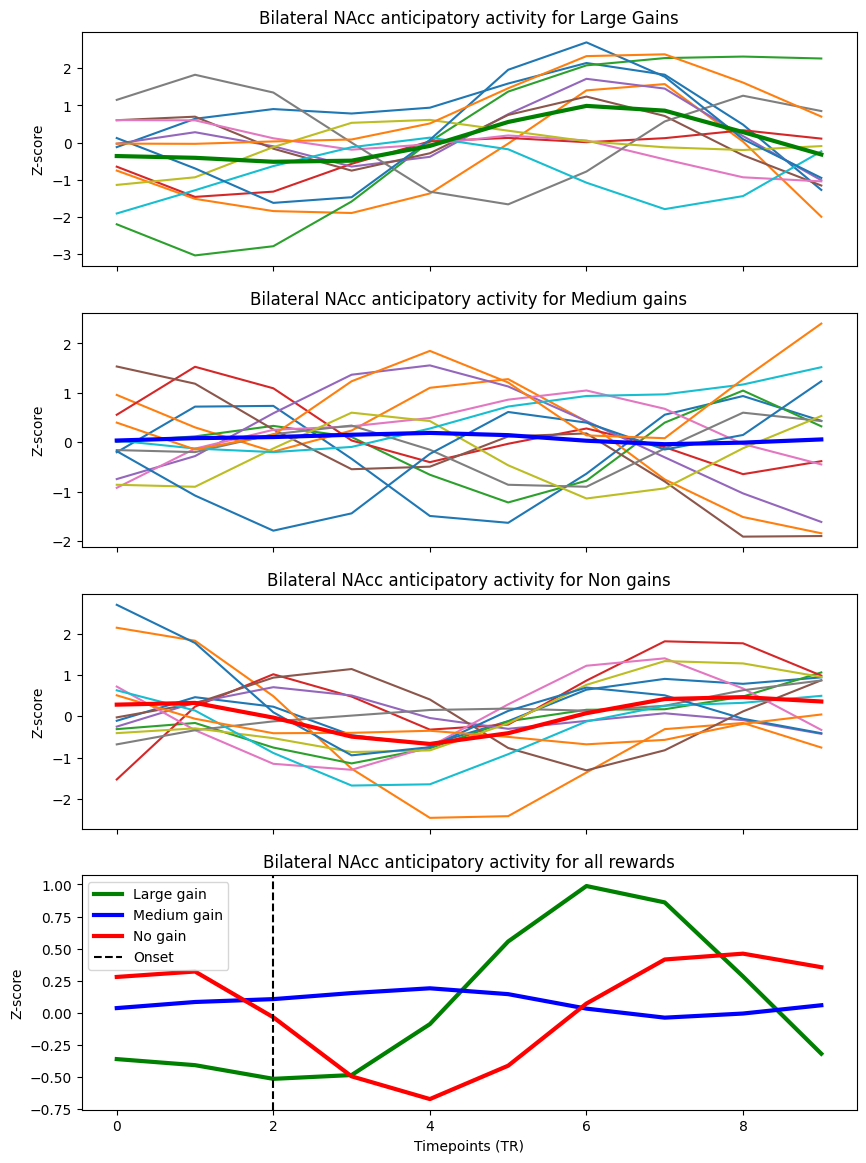

In [553]:
fig, axs = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

for x in range(12):
    axs[0].plot(bold_pNAcc_lg[x][:])
    axs[1].plot(bold_pNAcc_mg[x][:])
    axs[2].plot(bold_pNAcc_ng[x][:])

#axs[0].set_ylim(-100, 150)
#axs[1].set_ylim(-100, 150)
#axs[2].set_ylim(-100, 150)
axs[0].set_ylabel('Z-score')
axs[1].set_ylabel('Z-score')
axs[2].set_ylabel('Z-score')
axs[0].set_title("Bilateral NAcc anticipatory activity for Large Gains")
axs[1].set_title("Bilateral NAcc anticipatory activity for Medium gains")
axs[2].set_title("Bilateral NAcc anticipatory activity for Non gains")

axs[0].plot(bold_pNAcc_lg_mean[:], 'g', lw=3)
axs[1].plot(bold_pNAcc_mg_mean[:], 'b', lw=3)
axs[2].plot(bold_pNAcc_ng_mean[:], 'r', lw=3)

axs[3].plot(bold_pNAcc_lg_mean[:], 'g', lw=3)
axs[3].plot(bold_pNAcc_mg_mean[:], 'b', lw=3)
axs[3].plot(bold_pNAcc_ng_mean[:], 'r', lw=3)
axs[3].axvline(x = 2, color = 'k', label = 'onset', linestyle='dashed')

axs[3].legend(('Large gain', 'Medium gain', 'No gain', 'Onset'))
axs[3].set_ylabel('Z-score')
axs[3].set_xlabel('Timepoints (TR)')
axs[3].set_title("Bilateral NAcc anticipatory activity for all rewards")


In [ ]:
"""
Okay, so lets plot -TR onset and +3TR onset.

# Index each condition from the NAcc time series.
bold_sNAcc_lg = bold_sNAcc[large_gain_vol_onsets == 1, :]
bold_sNAcc_mg = bold_sNAcc[medium_gain_vol_onsets == 1, :]
bold_sNAcc_ng = bold_sNAcc[non_gain_vol_onsets == 1, :]

print("bold_sNAcc_lg has a shape: %s" % str(bold_sNAcc_lg.shape))
print("bold_sNAcc_mg has a shape: %s" % str(bold_sNAcc_mg.shape))
print("bold_sNAcc_ng has a shape: %s" % str(bold_sNAcc_ng.shape))

# Average time series from left and right NAcc. 
bold_sNAcc_lg_mean = np.mean(bold_sNAcc_lg, axis=1)
bold_sNAcc_mg_mean = np.mean(bold_sNAcc_mg, axis=1)
bold_sNAcc_ng_mean = np.mean(bold_sNAcc_ng, axis=1)
"""

"""
plt.figure(figsize=(14, 4))
plt.title('Avg bilateral NAcc ROI activity for large, medium and non gain conditions.')
plt.plot(-1*bold_sNAcc_lg_mean, 'g')
plt.plot(-1*bold_sNAcc_mg_mean, 'b')
plt.plot(-1*bold_sNAcc_ng_mean, 'r')
plt.legend(('Large gain', 'Medium gain', 'No gain'))
#plt.ylabel('Evoked activity')
plt.xlabel('Timepoints (TR)')
"""

# Define the LSA model

In [236]:
# Transform the DataFrame for LSA
lsa_events_df = run1_events.copy()
conditions = lsa_events_df["trial_type"].unique()
condition_counter = {c: 0 for c in conditions}
for i_trial, trial in lsa_events_df.iterrows():
    trial_condition = trial["trial_type"]
    # Check if the trial_condition doesn't contain 'outcome' or 'response'
    if 'outcome' not in trial_condition and 'response' not in trial_condition:
        condition_counter[trial_condition] += 1
        trial_name = f"{trial_condition}__{condition_counter[trial_condition]:03d}"
        
        # Assign the modified trial_name to the DataFrame
        lsa_events_df.loc[i_trial, "trial_type"] = trial_name


In [234]:
lsa_glm = FirstLevelModel(t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5,
    mask_img=sub01_run1_mask_file,
    smoothing_fwhm = 4)

lsa_glm.fit(sub01_run1_func_file, lsa_events_df)

FirstLevelModel(high_pass=0.011, hrf_model='spm',
                mask_img='MID_preproc/sub-01/func/sub-01_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                noise_model='ols', slice_time_ref=0.5, smoothing_fwhm=4, t_r=2)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_23903/3685210562.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


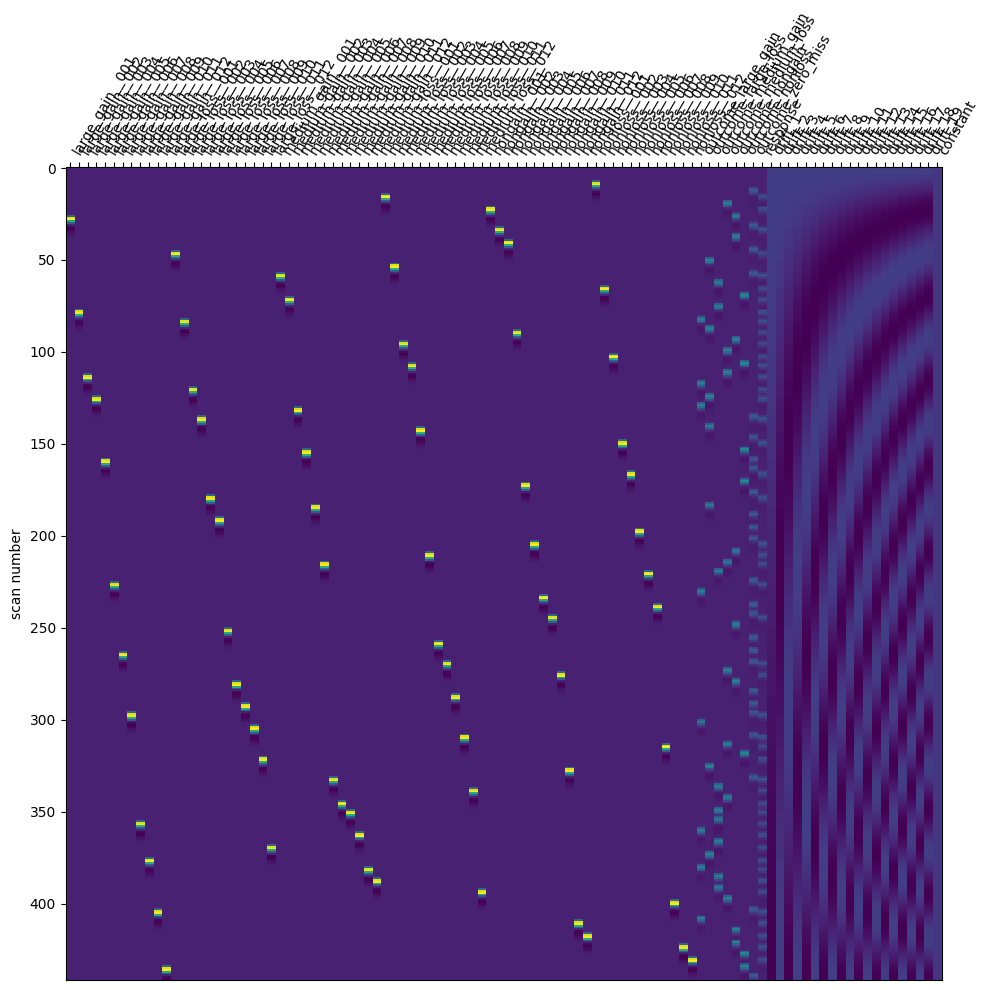

In [235]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_design_matrix(lsa_glm.design_matrices_[0], ax=ax)
fig.show()

In [262]:

lsa_beta_maps = {cond: [] for cond in run1_events["trial_type"].unique()}
trialwise_conditions = lsa_events_df["trial_type"].unique()

# Filter out values containing 'outcome' or 'response'
trialwise_conditions = np.array([x for x in trialwise_conditions if 'outcome' not in str(x) and 'response' not in str(x)])

for condition in trialwise_conditions:
    beta_map = lsa_glm.compute_contrast(condition, output_type="effect_size")
    # Drop the trial number from the condition name to get the original name
    condition_name = condition.split("__")[0]
    lsa_beta_maps[condition_name].append(beta_map)
    

# Filter out empty entries
lsa_beta_maps = {key: value for key, value in lsa_beta_maps.items() if value}


In [265]:
# We can concatenate the lists of 3D maps into a single 4D beta series for
# each condition, if we want
lsa_beta_maps = {name: concat_imgs(maps) for name, maps in lsa_beta_maps.items()}

lsa_beta_maps

{'nonloss': <nibabel.nifti1.Nifti1Image at 0x7f7fa892e910>,
 'medium_loss': <nibabel.nifti1.Nifti1Image at 0x7f7fa891a5e0>,
 'nongain': <nibabel.nifti1.Nifti1Image at 0x7f7fc6c2e7f0>,
 'large_gain': <nibabel.nifti1.Nifti1Image at 0x7f7f909eeca0>,
 'large_loss': <nibabel.nifti1.Nifti1Image at 0x7f7f909eea30>,
 'medium_gain': <nibabel.nifti1.Nifti1Image at 0x7f7fc6c725e0>}

In [268]:
lsa_beta_maps["large_gain"]
# Can be used for PPI analysis. 

(58, 69, 58, 12)

# Define the LSS models

# Slice func file to difference events. 

In [ ]:
n_timepoints
run1_events_raw[0:72]

,onset,duration,trial,trial_type,target_s,response_time,hit,total_gain,iti
0,12.0001,10,1,-$0,0.25,-1.00000,0,$0.00,6
1,26.0008,10,2,-$1,0.25,0.20167,1,$0.00,6
2,40.0008,6,3,+$0,0.25,0.21764,1,$0.00,2
3,50.0008,8,4,+$5,0.25,-1.00000,0,$0.00,4
4,62.0006,10,5,+$0,0.25,0.19340,1,$0.00,6
...,...,...,...,...,...,...,...,...,...
67,816.0011,10,68,+$0,0.25,0.22042,1,$20.00,6
68,830.0008,8,69,+$0,0.27,0.22042,1,$20.00,4
69,842.0007,10,70,-$0,0.25,0.19673,1,$20.00,6
70,856.0008,6,71,-$0,0.27,0.25828,1,$20.00,2


In [ ]:
large_gain_onsets = np.array(run1_events[run1_events["trial_type"] == "large_gain"]["onset"]).astype(int)
large_gain_onsets


array([ 50, 152, 222, 246, 314, 448, 524, 590, 708, 748, 804, 866])

In [ ]:
from scipy.interpolate import interp1d
# Down-sample predictors to get vol onsets. 

time_scale = np.arange(0, n_timepoints, 1)  
large_gain_time_onsets = np.zeros(n_timepoints)
large_gain_time_onsets[large_gain_onsets] = 1

print("Time scale has %i datapoints" % time_scale.size)
resampler = interp1d(time_scale, large_gain_time_onsets)

vol_scale = np.arange(0, n_timepoints, TR)  
print("Vol scale has %i datapoints" % vol_scale.size)
large_gain_vol_onsets = resampler(vol_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % large_gain_vol_onsets.size)


Time scale has 884 datapoints
Vol scale has 442 datapoints
Downsampled predictor has 442 datapoints (in volumes)


In [ ]:
TR = 2
osf = 2
length_hrf = 32 

spm_hrf_c = spm_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
spm_hrf_c /= spm_hrf_c.max()

In [ ]:
convolved_large_gain_vol_onsets = np.convolve(large_gain_vol_onsets, spm_hrf_c, 'full')

convolved_large_gain_vol_onsets = convolved_large_gain_vol_onsets[:large_gain_vol_onsets.size]
convolved_large_gain_vol_onsets.shape
#convolved_large_gain_vol_onsets

(442,)

In [ ]:
large_gain_vol_onsets.shape

(442,)

# Apply Atlas to data.

In [ ]:
Pauili_masker = NiftiMapsMasker(
    t_r=TR,
    maps_img=pauli_file,
    smoothing_fwhm=4, 
    standardize="zscore",
    standardize_confounds=True,
    high_pass=0.011,
    low_pass=0.1,
    resampling_target="data")

In [ ]:
sub01_time_series = Pauili_masker.fit_transform(sub01_run1_func_file, confounds=sub01_run1_filtered_confounds_df)
sub01_NAcc_time_series = sub01_time_series[:, 2]
sub01_NAcc_time_series.shape

(442,)

In [ ]:
#convolved_large_gain_vol_onsets

In [351]:
# Find transitions from non-zero to zero in the stimulus vector
indices = np.where((convolved_large_gain_vol_onsets[:-1] != 0) & (convolved_large_gain_vol_onsets[1:] == 0))[0] + 1

# Define the desired length for each window
window_length = 6

# Extract time-course activity for each stimulus window
time_windows_activity = []
for i, onset_index in enumerate(indices):
    if i == len(indices) - 1:
        end_index = len(convolved_large_gain_vol_onsets)
    else:
        end_index = indices[i + 1]
    
    # Extract the time-course data within the defined window
    window_activity = sub01_NAcc_time_series[onset_index-1:end_index]
    
    # Trim or pad the window to the desired length
    if len(window_activity) < window_length:
        padded_window = np.pad(window_activity, (0, window_length - len(window_activity)), mode='constant')
        time_windows_activity.append(padded_window)
    else:
        trimmed_window = window_activity[:window_length]
        time_windows_activity.append(trimmed_window)

# Convert the list of time windows activity to numpy array for further analysis
time_windows_activity = np.array(time_windows_activity)
time_windows_activity.shape


(7, 6)

In [352]:
time_windows_activity[1].shape
time_course_mean = np.mean(time_windows_activity, axis=0)
time_course_mean.shape

(6,)

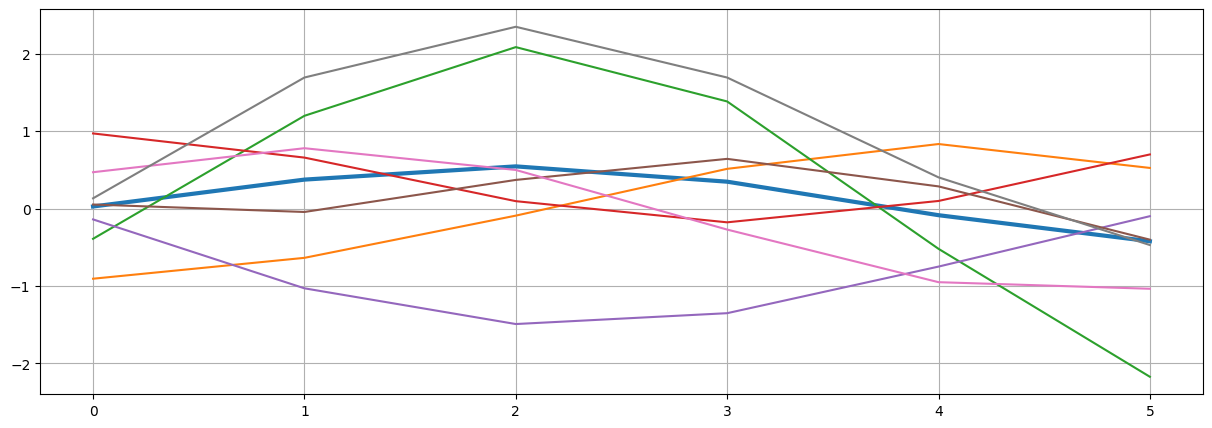

In [353]:
plt.figure(figsize=(15, 5))
plt.plot(time_course_mean, lw=3)
plt.plot(time_windows_activity[0])
plt.plot(time_windows_activity[1])
plt.plot(time_windows_activity[2])
plt.plot(time_windows_activity[3])
plt.plot(time_windows_activity[4])
plt.plot(time_windows_activity[5])
plt.plot(time_windows_activity[6])
plt.grid()
#plt.title('Downsampled/convolved predictor + signal', fontsize=20)
#plt.ylabel('Activity (A.U.)', fontsize=15)
#plt.xlabel('Time (seconds)', fontsize=15)
#plt.legend(['Predictor', 'Signal'])
#plt.xlim(x_lim)
plt.show()